In [48]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os
import glob
from torchvision import transforms
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)

    return image

In [7]:
image_path = 'data/images/elephants.png' 
encoder_path = 'models/encoder512-10-3000.ckpt'
decoder_path = 'models/decoder512-10-3000.ckpt'
vocab_path = 'data/vocab.pkl'
embed_size = 512
hidden_size = 512
num_layers = 1

In [11]:
def main(image, encoder_path, decoder_path, vocab_path, embed_size, hidden_size, num_layers):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Build models
    # eval mode (batchnorm uses moving mean/variance)
    encoder = EncoderCNN(embed_size).eval()
    decoder = DecoderRNN(
        embed_size,
        hidden_size,
        len(vocab),
        num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load the trained model parameters
    try:
        if torch.cuda.is_available():
            encoder.load_state_dict(torch.load(encoder_path))
        else:
            encoder.load_state_dict(
                torch.load(
                    encoder_path,
                    map_location=torch.device('cpu')))
    except BaseException as e:
        print(e)
    try:
        if torch.cuda.is_available():
            decoder.load_state_dict(torch.load(decoder_path))
        else:
            decoder.load_state_dict(
                torch.load(
                    decoder_path,
                    map_location=torch.device('cpu')))
    except BaseException as e:
        print(e)

    # Prepare an image
    image = load_image(image, transform)
    image_tensor = image.to(device)

    # Generate an caption from the image
    with torch.no_grad():
        feature = encoder(image_tensor)
        sampled_ids = decoder.sample(feature)
    # (1, max_seq_length) -> (max_seq_length)
    sampled_ids = sampled_ids[0].cpu().numpy()

    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    return sentence

In [44]:
image_paths = [
    'data/resized2014/coco_val_0.jpg',
    'data/resized2014/coco_val_1.jpg',
    'data/resized2014/coco_val_2.jpg',
    'data/resized2014/coco_val_5.jpg',
    'data/resized2014/coco_val_6.jpg',
    'data/resized2014/coco_val_7.jpg',
    'data/resized2014/coco_val_8.jpg',
    'data/resized2014/coco_val_9.jpg',
]

In [49]:
image_paths = glob.glob("./data/resized2014/coco*")

/var/folders/8h/gq3wkjn971g716fqf8xqlpch0000gn/T/ipykernel_1711/3292350696.py:3: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize([224, 224], Image.LANCZOS)


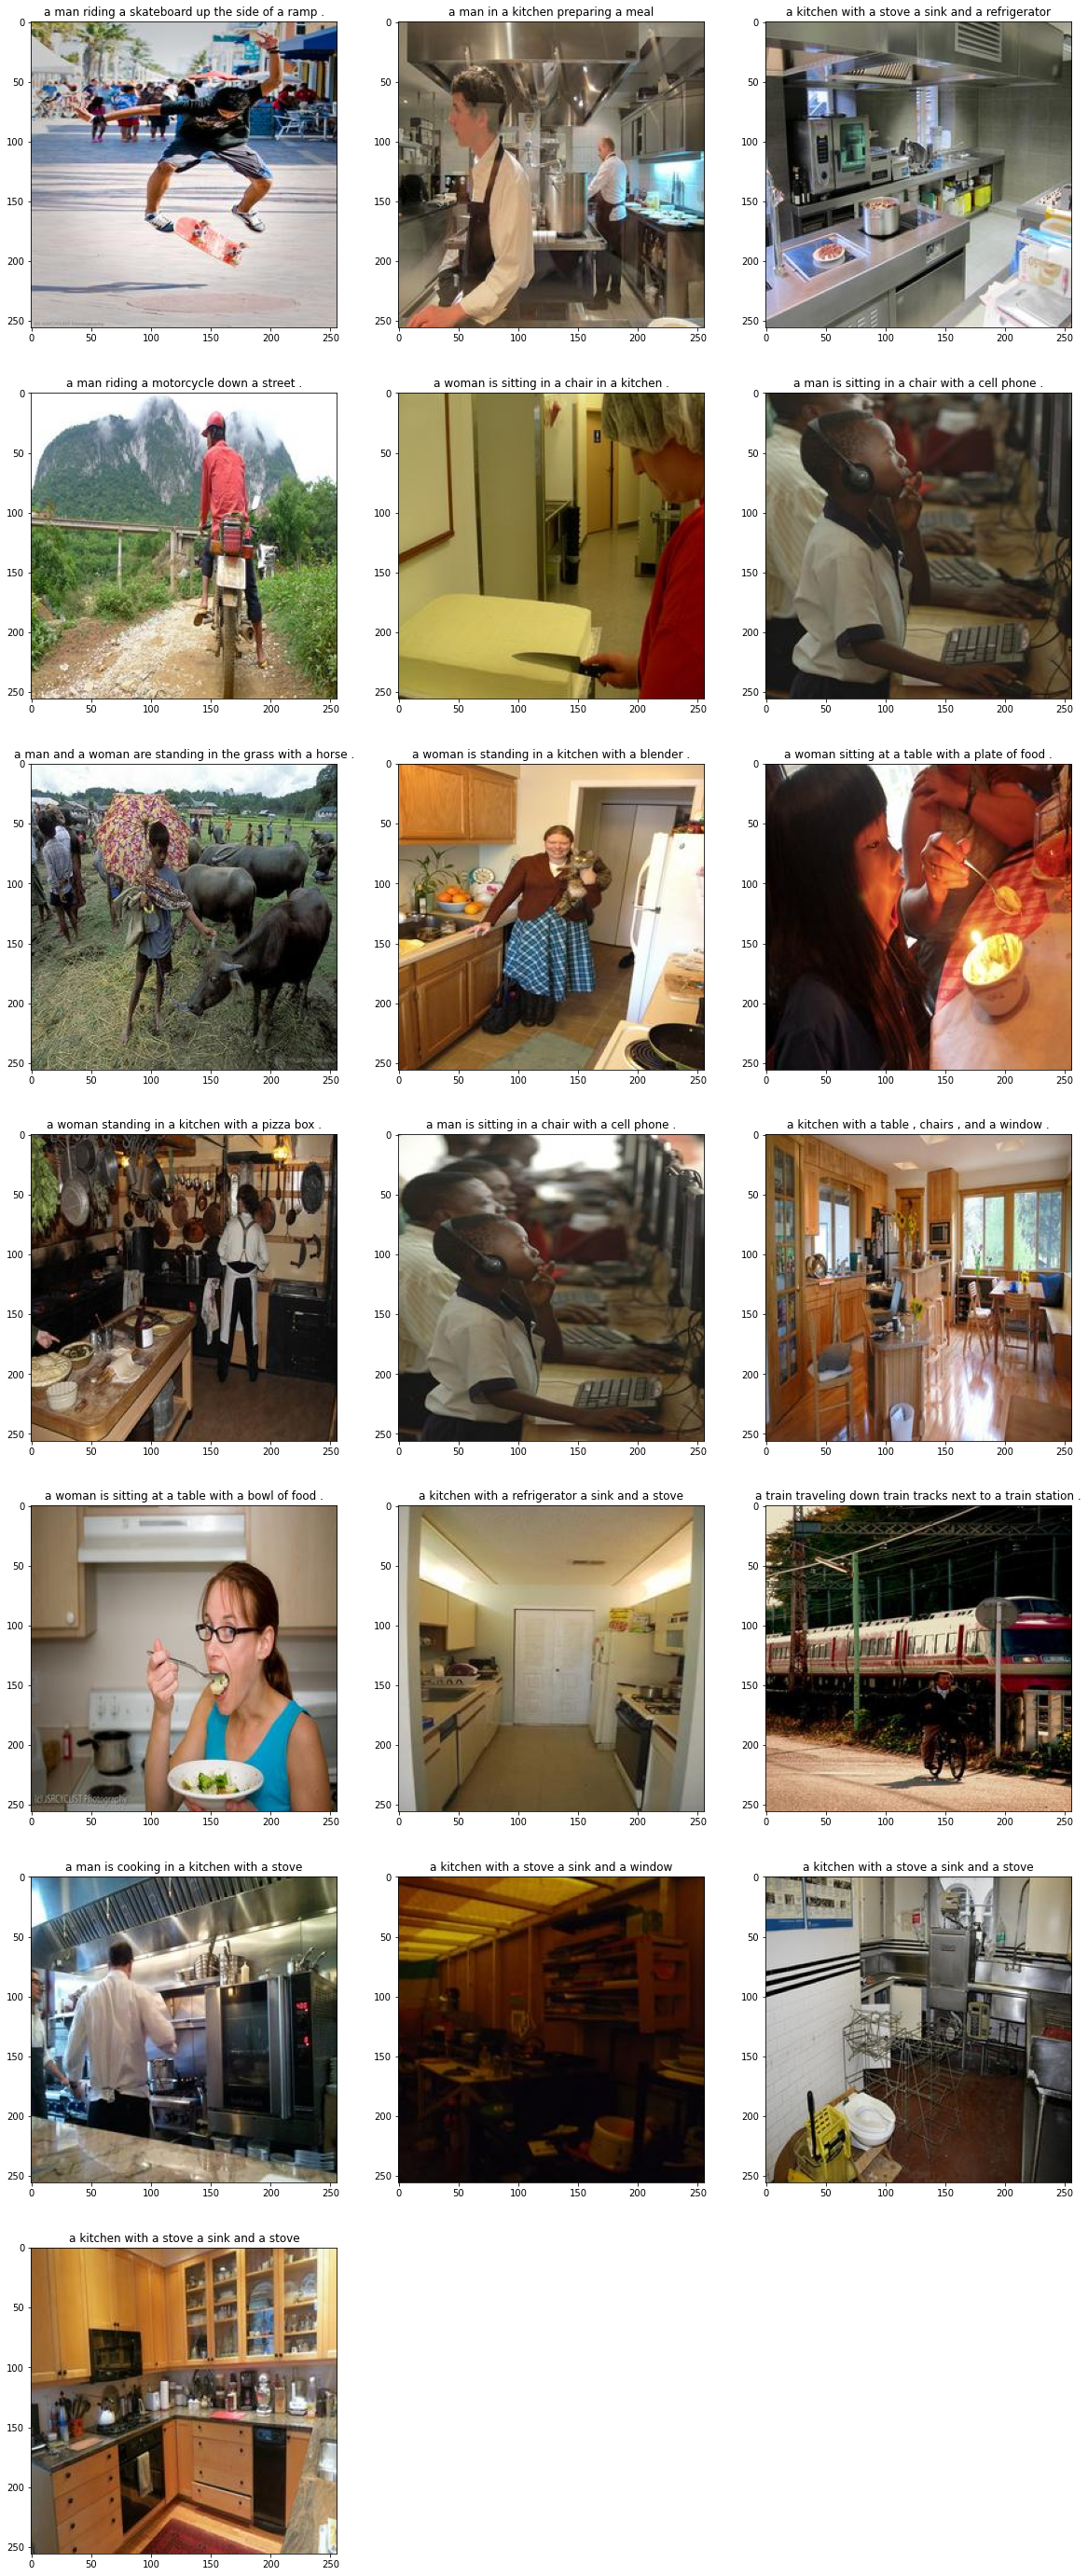

In [52]:
fig = plt.figure()
fig.set_size_inches(20, 50)
axs = []
width = 3
for i in range(len(image_paths)):
    caption = main(image_paths[i], encoder_path, decoder_path, vocab_path, embed_size, hidden_size, num_layers)
    ax = fig.add_subplot(len(image_paths)//width + 1, width, i+1)
    ax.set_title(caption[8:-6])
    axs.append(ax)
for i in range(len(axs)):
    image = Image.open(image_paths[i])
    axs[i].imshow(image)